# Brain Tumor Classifier Using Convolutional Neural Network (CNN)
## Summary
I was tasked with creating a model to predict what type of brain tumor a patient has (if any) among five classes given an image of an MRI. This model can be offered by the American College of Radiology to facilities it accredits to aid in diagnosing brain tumors.

I used two datasets:
- 7,023 total T1C-enhanced MRI images of pituitary, meningioma, and glioma, as well as images of brains with no tumors.  These images are from a [dataset available on Kaggle from Masoud Nickparvar.](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- A subset of 1,177 "other" tumor MRI images from a [dataset available on Kaggle from Fernando Feltrin.](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c) In constructing this "other" class, I used only T1C-enhanced MRI images from tumor types not included in the first dataset.

From this data, I constructed an overall dataset with five classes (pituitary, meningioma, glioma, no tumor, other tumor). When building my models, I prioritized maximizing accuracy - the overall proportion of correct predictions by the model. In refining this model in the future I would likely prioritize recall most highly since a false negative is a potentially fatal error, but given the limited scope of the training data accuracy felt appropriate for now.

My preprocessing included splitting the data into train and test sets, and using image augmentation to increase the size of the training data. I tested a variety of different CNN architectures, eventually settling on a relatively simple model with two convolutional and max pooling layers, two dense layers, and a classification layer. The model achieved roughly a 90.9% accuracy score on test data.

## Business Understanding
According to the [National Brain Tumor Society](https://braintumor.org/brain-tumors/about-brain-tumors/brain-tumor-facts/), an estimated 700,000 people in the United States are living with a primary brain tumor. Over 94,000 people will receive a brain tumor diagnosis in 2023, and over 18,000 people will die as a result of brain tumors. Even so-called "benign" tumors can have massively deleterious impacts on a patient's quality of life - and malignant tumors such as gliomas can often be fatal.

Accurate classification of tumor type is a key step in the treatment process. Yet according to the [National Cancer Institute, as of 2020 5-10% of people with a brain tumor receive an incorrect diagnosis.](https://www.cancer.gov/rare-brain-spine-tumor/blog/2020/brain-tumors-diagnosed-treated) This may be in part because there are hundreds of different types of brain tumors, as [classified by the World Health Organization.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8328013/) A deep learning model that is properly trained on MRI images from patients with a wide variety of brain tumors could be a valuable tool available to clinicians conducting MRIs on patients seeking care for brain tumor symptoms.

Existing deep learning models tend to focus on only 3 classes of tumors (pituitary, meningioma, and glioma) due to the limited availability of MRI images. Some models also include a "healthy" or "no tumor" category. While some publicly-available data exists for other tumor types, the sample sizes are too small for true deep learning. This project seeks to build on existing literature by adding one additional class to these - an "other tumor" class that includes images from MRIs taken of patients with rarer tumor types.

An accurate tumor classification model that is trained on a broader array of data than existing models has the potential to be enormously useful to a stakeholder such as facilities accredited by the American College of Radiology, who will see patients with a wide variety of different tumor types.

In [29]:
# Imports

# For Data Processing And Evaluation
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# For image manipulation
import cv2
import imutils

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, AveragePooling2D, concatenate, GlobalAveragePooling2D, LeakyReLU, Softmax, ReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras import layers
from keras.models import Model

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Miscellaneous
import os
import shutil
import random

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable and wider
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option('max_colwidth', 400)

## Data Understanding and Preparation
I used two datasets:
- 7,023 total T1C-enhanced MRI images of pituitary, meningioma, and glioma, as well as images of brains with no tumors.  These images are from a [dataset available on Kaggle from Masoud Nickparvar.](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- A subset of 1,177 "other" tumor MRI images from a [dataset available on Kaggle from Fernando Feltrin.](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c) In constructing this "other" class, I used only T1C-enhanced MRI images from tumor types not included in the first dataset.

The use of this second dataset is what allowed me to construct the "other" category, which differentiates this model from many other proposed approaches.

In [2]:
# specify local directories for training and testing data
train_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/'
test_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/'

# Create a new directory named "other" in the train directory
new_train_dir = os.path.join(train_dir, 'other')
if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)

# Create a new directory named "other" in the test directory
new_test_dir = os.path.join(test_dir, 'other')
if not os.path.exists(new_test_dir):
    os.makedirs(new_test_dir)

We'll need to move the relevant images from the folder with the second dataset to the training and test folders. We'll use about 80% of the images in our training data, and the remaining 20% in our test data.

In [3]:
# specify folders with images to move from second dataset
supplement_labels = ['Astrocitoma T1C+', 'Carcinoma T1C+', 'Ependimoma T1C+', 'Ganglioglioma T1C+',
                'Germinoma T1C+', 'Granuloma T1C+', 'Meduloblastoma T1C+', 'Neurocitoma T1C+',
                'Oligodendroglioma T1C+', 'Papiloma T1C+', 'Schwannoma T1C+', 'Tuberculoma T1C+']

# specify path with images from second dataset
supplement_path = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/supplement/'

# move 80% of images to the new "other" directory in train_dir and 20% to the new "other" directory in test_dir
for label in supplement_labels:
    folder_path = os.path.join(supplement_path, label)
    files = os.listdir(folder_path)
    random.shuffle(files)
    num_files = len(files)
    num_train_files = int(num_files * 0.8)
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]
    files_moved = 0
    
    for filename in train_files:
        if filename.endswith((".jpg", ".jpeg")):
            src_path = os.path.join(folder_path, filename)
            if os.path.isfile(src_path):
                dst_path = os.path.join(new_train_dir, filename)
                shutil.move(src_path, dst_path)

    for filename in test_files:
        if filename.endswith((".jpg", ".jpeg")):
            src_path = os.path.join(folder_path, filename)
            if os.path.isfile(src_path):
                dst_path = os.path.join(new_test_dir, filename)
                shutil.move(src_path, dst_path)

Now that the images are all in the right place, we can create our training and test sets. We'll make corresponding lists of filepaths and labels, and store the information in a DataFrame to use in our ImageDataGenerators later.

In [4]:
# list of labels corresponding to folders
labels = ['pituitary', 'notumor', 'meningioma', 'glioma', 'other']

# initialize empty lists
X_train = []
y_train = []

# add filepaths and labels to train lists
for label in labels:
    for image in os.listdir(train_dir+label):
        X_train.append(train_dir+label+'/'+image)
        y_train.append(label)

In [5]:
# initialize empty lists
X_test = []
y_test = []

# add filepaths and labels to test lists
for label in labels:
    for image in os.listdir(test_dir+label):
        X_test.append(test_dir+label+'/'+image)
        y_test.append(label)

In [6]:
# shuffle lists
X_train, y_train = shuffle(X_train, y_train)

In [7]:
# create dataframe for later use
tumor_train_df = pd.concat([pd.Series(X_train, name = 'paths'), 
                            pd.Series(y_train, name = 'label')], 
                            axis = 1)
tumor_train_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0503.jpg,notumor
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_0850.jpg,glioma
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_1258.jpg,pituitary
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0764.jpg,notumor
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0696.jpg,meningioma
...,...,...
6638,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_0260.jpg,glioma
6639,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_1054.jpg,glioma
6640,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1308.jpg,notumor
6641,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_1189.jpg,meningioma


In [8]:
# shuffle lists
X_test, y_test = shuffle(X_test, y_test)

In [9]:
# create dataframe for later use
tumor_test_df = pd.concat([pd.Series(X_test, name = 'paths'), 
                            pd.Series(y_test, name = 'label')], 
                            axis = 1)
tumor_test_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0153.jpg,notumor
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0353.jpg,notumor
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0285.jpg,notumor
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0388.jpg,notumor
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0023.jpg,glioma
...,...,...
1552,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0293.jpg,notumor
1553,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/03ad5701df444374ddb9f73c019c77_big_gallery.jpeg,other
1554,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/meningioma/Te-me_0241.jpg,meningioma
1555,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0210.jpg,pituitary


Now that we have training and test DataFrames, let's take a look at some of the characteristics of our data.

### Exploratory Data Analysis

Let's look at the distribution of our target variable - tumor types.

In [10]:
tumor_train_df['label'].value_counts(normalize = True)

notumor       0.240102
pituitary     0.219329
meningioma    0.201566
glioma        0.198856
other         0.140148
Name: label, dtype: float64

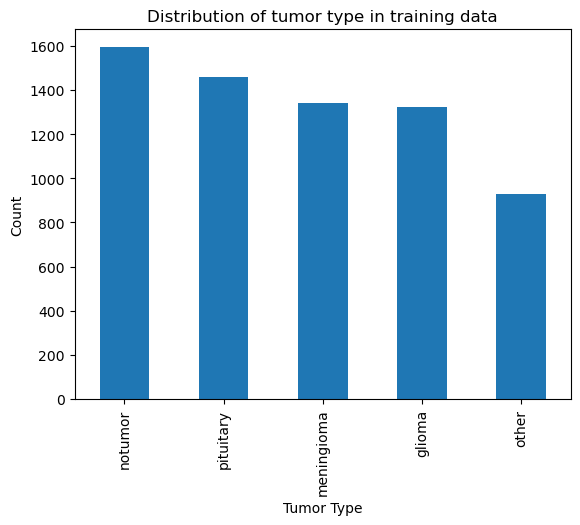

In [11]:
# instantiate figure
fig, ax = plt.subplots()

# plot histogram of tumor types
tumor_train_df['label'].value_counts().plot(kind = 'bar')

#set title and axis labels
ax.set_title('Distribution of tumor type in training data')
ax.set_ylabel('Count')
ax.set_xlabel('Tumor Type');

Our training classes are slightly imbalanced, but not terribly so.

In [12]:
tumor_test_df['label'].value_counts(normalize = True)

notumor       0.260116
meningioma    0.196532
glioma        0.192678
pituitary     0.192678
other         0.157996
Name: label, dtype: float64

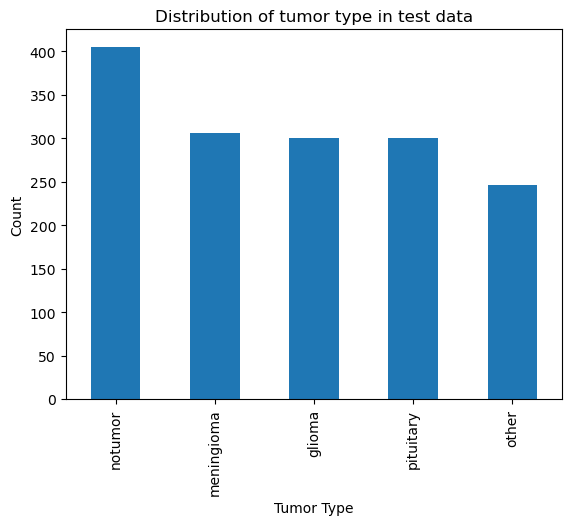

In [13]:
# instantiate figure
fig, ax = plt.subplots()

# plot tumor types
tumor_test_df['label'].value_counts().plot(kind = 'bar')

# set title and axis labels
ax.set_title('Distribution of tumor type in test data')
ax.set_ylabel('Count')
ax.set_xlabel('Tumor Type');

The test data is the same - imbalanced, but not alarmingly so. Based on this distribution of classes, we would expect a naive model that simply predicts the majority class every time to achieve an accuracy of about 26%.

Let's take a look at some of these MRI images.

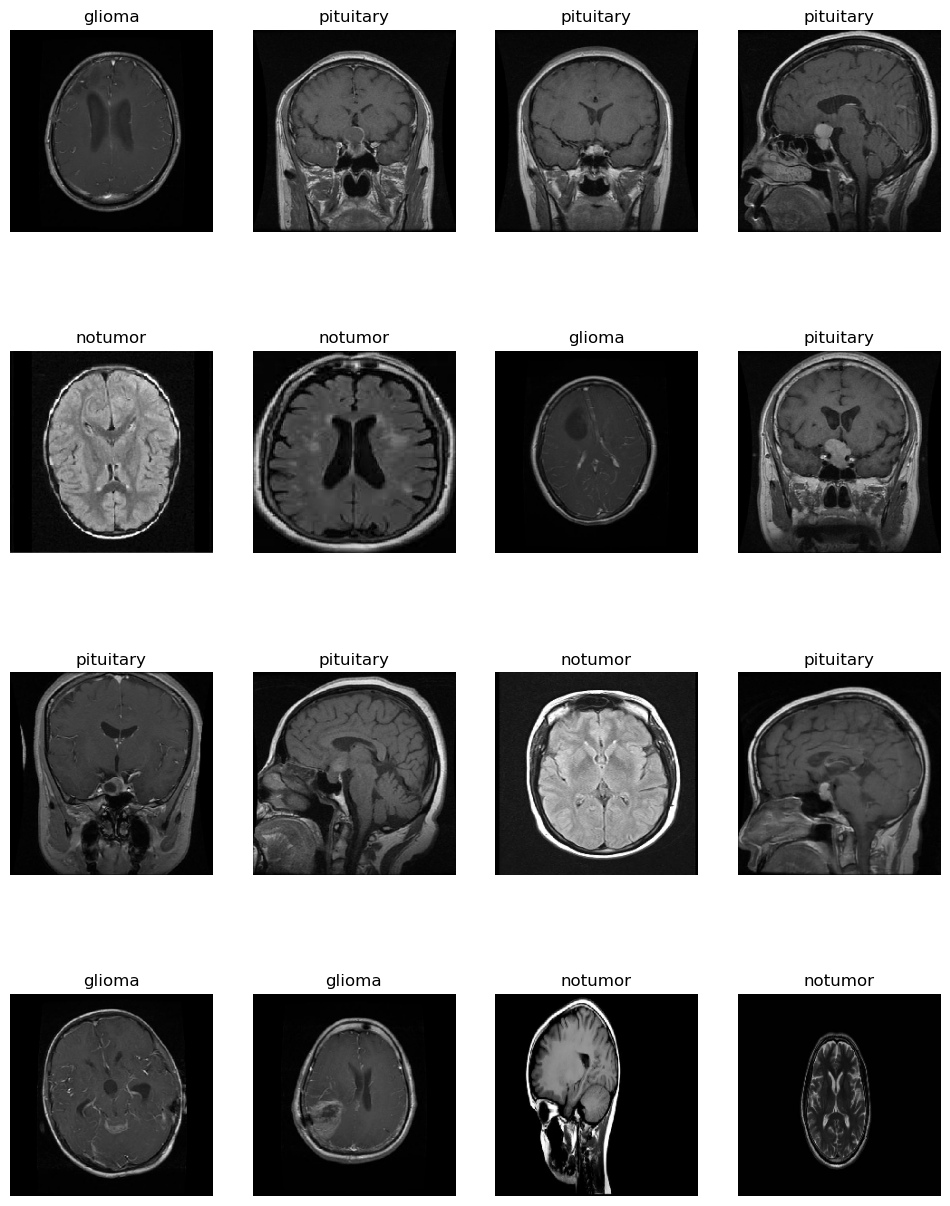

In [14]:
# with gratitude to MD Mushfirat Mohaimin for this code
# https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96

IMAGE_SIZE = (224, 224)

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays.
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=IMAGE_SIZE)
        images.append(image)
    return np.array(images, dtype=object)

# open 16 images
images = open_images(X_train[50:67])
labels = y_train[50:67]
fig = plt.figure(figsize=(12, 16))
for x in range(1, 17):
    fig.add_subplot(4, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

They appears to be taken from different angles, but are all grayscale. The images with tumors of any kind appear distinct from images with no tumors, which makes sense. Pituitary tumors seem localized in one spot (the pituitary gland, at the base of the brain), whereas gliomas, meningiomas, and other tumors are distributed elsewhere in the brain. Let's construct a simple baseline model as a starting point.

## Baseline Model

For this model, we will use a single dense layer with 64 neurons before our output layer. We will not perform any image augmentation for now - we just want to get the simplest possible baseline sense of the model's accuracy.

In [15]:
# rescale images
train_datagen_baseline = ImageDataGenerator(rescale=1./255)
test_datagen_baseline = ImageDataGenerator(rescale=1./255)
batch_size = 32

# generate image data from training df
train_generator_baseline = train_datagen_baseline.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

# generate image data from test df
test_generator_baseline = test_datagen_baseline.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [37]:
# specify hyperparamters for model
cce = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()
es = EarlyStopping(monitor='loss', patience=5)

# define learning rate scheduler
def scheduler(epoch, lr):
    lr = .001
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
sched = LearningRateScheduler(scheduler)

In [17]:
# instantiate model and add dense layer and output layer
model = Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

# compile model
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

Metal device set to: Apple M1 Pro


2023-04-14 18:56:33.865635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-14 18:56:33.865737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
base_model = model.fit(train_generator_baseline,
                       verbose = 1,
                       validation_data = test_generator_baseline, 
                       epochs=50,
                       callbacks = [es])

2023-04-14 18:56:34.039214: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2023-04-14 18:56:34.198778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.5637 - accuracy: 0.5973

2023-04-14 18:56:42.372655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 10s 47ms/step - loss: 1.5637 - accuracy: 0.5973 - val_loss: 1.1321 - val_accuracy: 0.6211
Epoch 2/50
208/208 [==============================] - 10s 46ms/step - loss: 0.7342 - accuracy: 0.7403 - val_loss: 0.8156 - val_accuracy: 0.6802
Epoch 3/50
208/208 [==============================] - 10s 47ms/step - loss: 0.6240 - accuracy: 0.7836 - val_loss: 0.7428 - val_accuracy: 0.7656
Epoch 4/50
208/208 [==============================] - 10s 48ms/step - loss: 0.4596 - accuracy: 0.8353 - val_loss: 0.6249 - val_accuracy: 0.7765
Epoch 5/50
208/208 [==============================] - 10s 47ms/step - loss: 0.4043 - accuracy: 0.8598 - val_loss: 0.6068 - val_accuracy: 0.7990
Epoch 6/50
208/208 [==============================] - 10s 47ms/step - loss: 0.3904 - accuracy: 0.8559 - val_loss: 0.7153 - val_accuracy: 0.7707
Epoch 7/50
208/208 [==============================] - 10s 47ms/step - loss: 0.3939 - accuracy: 0.8588 - val_loss: 0.5733 - val_accuracy: 0.8086
Epo

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 64)                3211328   
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 3,211,653
Trainable params: 3,211,653
Non-trainable params: 0
_________________________________________________________________


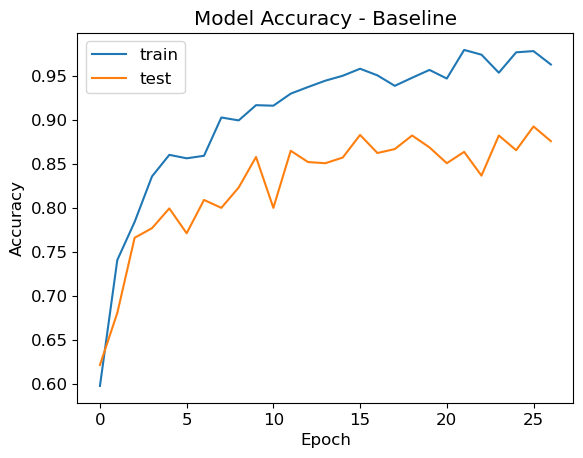

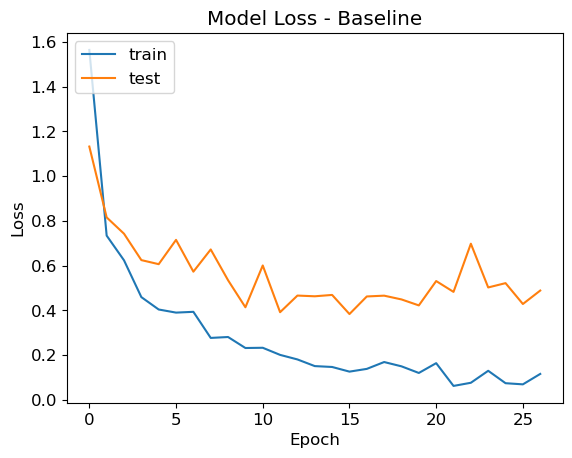

In [20]:
# summarize history for accuracy
plt.plot(base_model.history['accuracy'])
plt.plot(base_model.history['val_accuracy'])
plt.title('Model Accuracy - Baseline')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(base_model.history['loss'])
plt.plot(base_model.history['val_loss'])
plt.title('Model Loss - Baseline')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model peaked at around 76.75% accuracy on test data, which is better than a naive model but not nearly good enough to be deployed in clinical practice. It is also badly overfit to the training data. We can likely improve on this accuracy by augmenting our training data, and adding layers to the model.

## Data Augmentation and Second Model

For this second model, we'll augment our training images by flipping them horizontally and vertically; adjusting the brightness of images to make them darker or brighter; and rotating them slightly to account for potential rotational differences in test images. We won't perform any augmentation on the test images.

In [21]:
# instantiate generators with augmentation for training data
train_datagen_aug = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       brightness_range=[0.75, 1.25],
                                       rotation_range = 15)
test_datagen_aug = ImageDataGenerator(rescale=1./255)

# generate image data
train_generator_aug = train_datagen_aug.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=32,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

# generate image data
test_generator_aug = test_datagen_aug.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=32,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


For this model, we'll add in an additional dense layer, but more importantly we will add in two convolutional and pooling layers. Convolutional layers aid in feature extraction (such as edge detection) by using a defined filter to recognize patterns in the image. Max pooling layers are used to downsample the input image by taking only the maximum value from the defined window, which helps to consolidate the features learned by the convolutional layers. 

In [22]:
model_conv = Sequential()

# define 3x3 filter window sizes and create 32 filters
model_conv.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1)))
# max pool in 2x2 window
model_conv.add(layers.MaxPooling2D((2, 2)))

# define 3x3 filter window sizes and create 64 filters
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
# max pool in 2x2 window
model_conv.add(layers.MaxPooling2D((2, 2)))

model_conv.add(layers.Flatten())

# add dense layers and output layer
model_conv.add(layers.Dense(128, activation='relu'))
model_conv.add(layers.Dense(64, activation='relu'))
model_conv.add(layers.Dense(5, activation='softmax'))

# compile and fit model
model_conv.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

In [23]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [24]:
conv_model = model_conv.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50,
                       callbacks = [es])

Epoch 1/50


2023-04-14 19:01:00.110871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.1470 - accuracy: 0.5390

2023-04-14 19:01:21.822623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 24s 112ms/step - loss: 1.1470 - accuracy: 0.5390 - val_loss: 0.8537 - val_accuracy: 0.6699
Epoch 2/50
208/208 [==============================] - 23s 110ms/step - loss: 0.7354 - accuracy: 0.7025 - val_loss: 0.7310 - val_accuracy: 0.6814
Epoch 3/50
208/208 [==============================] - 23s 110ms/step - loss: 0.6175 - accuracy: 0.7481 - val_loss: 0.7282 - val_accuracy: 0.7168
Epoch 4/50
208/208 [==============================] - 23s 110ms/step - loss: 0.5565 - accuracy: 0.7811 - val_loss: 0.6194 - val_accuracy: 0.7585
Epoch 5/50
208/208 [==============================] - 23s 111ms/step - loss: 0.5083 - accuracy: 0.8016 - val_loss: 0.7108 - val_accuracy: 0.7315
Epoch 6/50
208/208 [==============================] - 23s 110ms/step - loss: 0.4649 - accuracy: 0.8222 - val_loss: 0.5921 - val_accuracy: 0.7765
Epoch 7/50
208/208 [==============================] - 23s 111ms/step - loss: 0.4235 - accuracy: 0.8374 - val_loss: 0.6471 - val_accuracy: 0.7

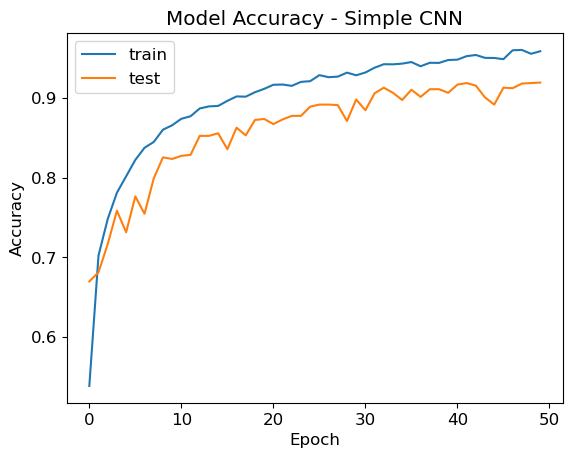

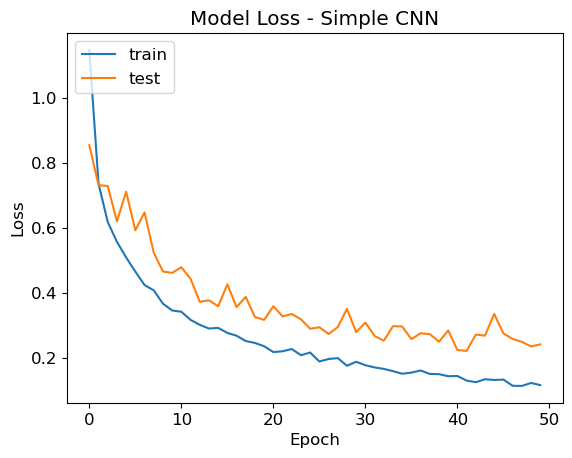

In [25]:
# summarize history for accuracy
plt.plot(conv_model.history['accuracy'])
plt.plot(conv_model.history['val_accuracy'])
plt.title('Model Accuracy - Simple CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(conv_model.history['loss'])
plt.plot(conv_model.history['val_loss'])
plt.title('Model Loss - Simple CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see, the accuracy rose for this model from the baseline considerably - from 76% to nearly 91%. We also reduced the overfitting observed in the baseline model, though not completely. Our next model will focus on trying to eliminate overfitting altogether.

## Model 3: With Regularization

We'll add some regularization to this model in the form of batch normalization, which makes the values in each layer more stable; dropout layers, which randomly set some of the outputs from the previous layer to zero during each epoch to encourage the network to learn more about more robust features and less about features of specific inputs; and kernel regularization applied to the convolutional layers, which functions similarly to the regularization penalties applied to other models. We'll also use a learning rate scheduler going forward, which automatically decays the value of the learning rate starting at a specified epoch to ensure changes made to the model weights later in the training process are smaller and thus less likely to result in overfitting.

In [30]:
# specify level of regularization
reg = l2(1e-2)

# instantiate model
model_conv_drop = Sequential()

# first conv layer
model_conv_drop.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1), kernel_regularizer = reg))
model_conv_drop.add(BatchNormalization())
model_conv_drop.add(layers.MaxPooling2D((2, 2)))

# second conv layer
model_conv_drop.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = reg))
model_conv_drop.add(layers.MaxPooling2D((2, 2)))

model_conv_drop.add(layers.Flatten())

# dense layers and output layer
model_conv_drop.add(layers.Dense(128, activation='relu'))
model_conv_drop.add(Dropout(0.3))
model_conv_drop.add(layers.Dense(64, activation='relu'))
model_conv_drop.add(layers.Dense(32, activation='relu'))
model_conv_drop.add(layers.Dense(5, activation='softmax'))

# compile model
model_conv_drop.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

In [31]:
model_conv_drop.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                      

In [32]:
conv_drop_model = model_conv_drop.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50,
                       callbacks = [es, sched])

Epoch 1/50


2023-04-14 20:09:14.060674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 2.2435 - accuracy: 0.3369

2023-04-14 20:09:37.689618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 26s 123ms/step - loss: 2.2435 - accuracy: 0.3369 - val_loss: 1.9216 - val_accuracy: 0.1927 - lr: 0.0010
Epoch 2/50
208/208 [==============================] - 25s 120ms/step - loss: 1.1938 - accuracy: 0.5687 - val_loss: 1.6455 - val_accuracy: 0.3269 - lr: 0.0010
Epoch 3/50
208/208 [==============================] - 25s 121ms/step - loss: 0.9215 - accuracy: 0.6709 - val_loss: 0.8782 - val_accuracy: 0.6879 - lr: 0.0010
Epoch 4/50
208/208 [==============================] - 25s 120ms/step - loss: 0.7705 - accuracy: 0.7234 - val_loss: 0.7416 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 5/50
208/208 [==============================] - 25s 120ms/step - loss: 0.6851 - accuracy: 0.7537 - val_loss: 0.6736 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 6/50
208/208 [==============================] - 25s 121ms/step - loss: 0.6394 - accuracy: 0.7695 - val_loss: 0.6177 - val_accuracy: 0.7624 - lr: 0.0010
Epoch 7/50
208/208 [==============================] - 25s 119ms

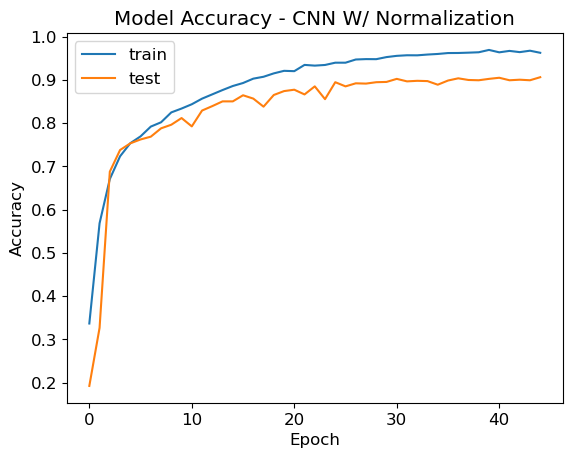

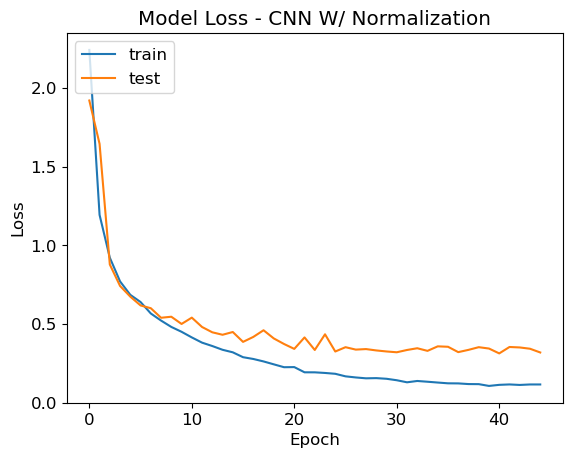

In [33]:
# summarize history for accuracy
plt.plot(conv_drop_model.history['accuracy'])
plt.plot(conv_drop_model.history['val_accuracy'])
plt.title('Model Accuracy - CNN W/ Normalization')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(conv_drop_model.history['loss'])
plt.plot(conv_drop_model.history['val_loss'])
plt.title('Model Loss - CNN W/ Normalization')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Strangely, the performance seems to have remained about the same from that of the prior model, but the overfitting issue got worse. Let's try a deeper model.

## Transfer Learning - VGG

Transfer learning is the use of a model developed for one task in a separate task. In this case, I will use the VGG-16 model, which is a 16-layer CNN originally developed for the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) computer vision competition. There are two approaches to transfer learning - the model can be "frozen" with its existing weights and used purely for feature extraction before the dense and output layers are added on, or parts can be "unfrozen" and fine-tuned on new data. I will start with the first approach.

In [44]:
# instantiate generators with augmentation and preprocessing for training data
train_datagen_vgg = ImageDataGenerator(rescale=1./255,
                                       preprocessing_function=keras.applications.vgg16.preprocess_input,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       brightness_range=[0.75, 1.25],
                                       rotation_range = 15)
test_datagen_vgg = ImageDataGenerator(rescale=1./255, 
                                      preprocessing_function=keras.applications.vgg16.preprocess_input)

# generate image data for training set
train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=32,
        class_mode='categorical',
        seed = 1990,
        shuffle = False)

# generate image data for test set
test_generator_vgg = test_datagen_vgg.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=32,
        class_mode='categorical',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [45]:
# instantiate vgg model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
output = vgg.layers[-1].output
output = layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# freeze layers
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
input_shape = vgg_model.output_shape[1]

In [46]:
# check model summary
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

As we can see, the model has over 14 million parameters - but none of them are trainable! Let's try fitting it to our data.

In [48]:
# instantiate model
vggmodel = Sequential()

# add vgg layers
vggmodel.add(vgg_model)
vggmodel.add(layers.Flatten())

# add dense layers and output layer
vggmodel.add(Dense(512, activation='relu', input_dim=input_shape))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(512, activation='relu'))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(5, activation='softmax'))

# compile and fit
vggmodel.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
vgg_model_feats = vggmodel.fit(train_generator_vgg,
                       verbose = 1,
                       validation_data = test_generator_vgg, 
                       epochs=50,
                       callbacks = [es, sched])

Epoch 1/50


2023-04-14 21:45:25.945988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.7487 - accuracy: 0.6012

2023-04-14 21:46:20.400549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 67s 320ms/step - loss: 1.7487 - accuracy: 0.6012 - val_loss: 0.7768 - val_accuracy: 0.6988 - lr: 0.0010
Epoch 2/50
208/208 [==============================] - 66s 316ms/step - loss: 0.6468 - accuracy: 0.7445 - val_loss: 0.6387 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/50
208/208 [==============================] - 66s 315ms/step - loss: 0.5424 - accuracy: 0.7930 - val_loss: 0.6059 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 4/50
208/208 [==============================] - 66s 315ms/step - loss: 0.4697 - accuracy: 0.8229 - val_loss: 0.4568 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 5/50
208/208 [==============================] - 66s 315ms/step - loss: 0.4396 - accuracy: 0.8320 - val_loss: 0.4863 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 6/50
208/208 [==============================] - 66s 316ms/step - loss: 0.3907 - accuracy: 0.8541 - val_loss: 0.4786 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 7/50
208/208 [==============================] - 67s 320ms

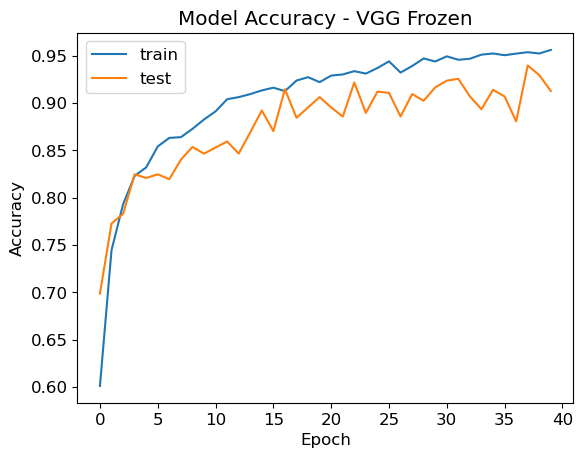

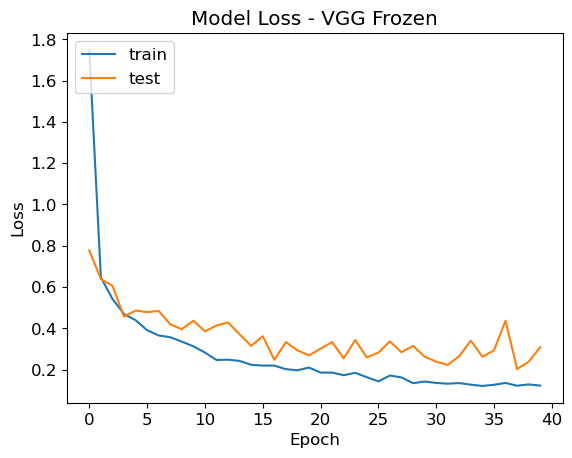

In [49]:
# summarize history for accuracy
plt.plot(vgg_model_feats.history['accuracy'])
plt.plot(vgg_model_feats.history['val_accuracy'])
plt.title('Model Accuracy - VGG Frozen')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_model_feats.history['loss'])
plt.plot(vgg_model_feats.history['val_loss'])
plt.title('Model Loss - VGG Frozen')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Again, the model performed similarly to the simple CNN - though with a much slower training time! Let's try fine-tuning it.

### VGG With Fine-Tuning

In [50]:
# instantiate vgg model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
output = vgg.layers[-1].output
output = layers.Flatten()(output)
vgg_model_finetune = Model(vgg.input, output)
input_shape = vgg_model_finetune.output_shape[1]

# set last convolutional layer to trainable
vgg_model_finetune.trainable = True
set_trainable = False
for layer in vgg_model_finetune.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [51]:
# examine model summary
vgg_model_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Now we can see that about half of the parameters are trainable. Let's try fitting the model to our data.

In [52]:
# instantiate model
vggmodel_finetune = Sequential()

# add VGG layers
vggmodel_finetune.add(vgg_model_finetune)

vggmodel_finetune.add(layers.Flatten())

# add dense layers and output layer
vggmodel_finetune.add(Dense(512, activation='relu', input_dim=input_shape))
vggmodel_finetune.add(Dropout(0.3))
vggmodel_finetune.add(Dense(512, activation='relu'))
vggmodel_finetune.add(Dropout(0.3))
vggmodel_finetune.add(Dense(5, activation='softmax'))

# compile and fit model
vggmodel_finetune.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
finetune_vgg = vggmodel_finetune.fit(train_generator_vgg,
                       verbose = 1,
                       validation_data = test_generator_vgg, 
                       epochs=50,
                       callbacks = [es, sched])

Epoch 1/50


2023-04-14 22:29:24.763085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 9.5606 - accuracy: 0.3829

2023-04-14 22:30:28.643225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 77s 365ms/step - loss: 9.5606 - accuracy: 0.3829 - val_loss: 1.0836 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 2/50
208/208 [==============================] - 76s 364ms/step - loss: 0.9307 - accuracy: 0.6054 - val_loss: 0.9051 - val_accuracy: 0.6243 - lr: 0.0010
Epoch 3/50
208/208 [==============================] - 77s 369ms/step - loss: 0.6799 - accuracy: 0.7459 - val_loss: 0.6652 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 4/50
208/208 [==============================] - 77s 370ms/step - loss: 0.5728 - accuracy: 0.7995 - val_loss: 0.6235 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 5/50
208/208 [==============================] - 77s 368ms/step - loss: 0.4942 - accuracy: 0.8211 - val_loss: 0.6124 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 6/50
208/208 [==============================] - 76s 366ms/step - loss: 0.4573 - accuracy: 0.8410 - val_loss: 0.5319 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 7/50
208/208 [==============================] - 77s 369ms

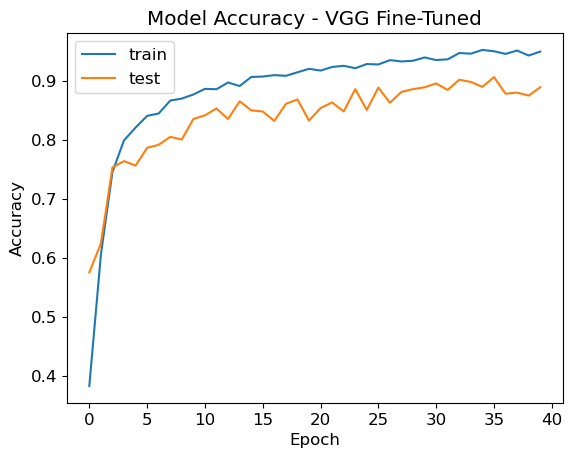

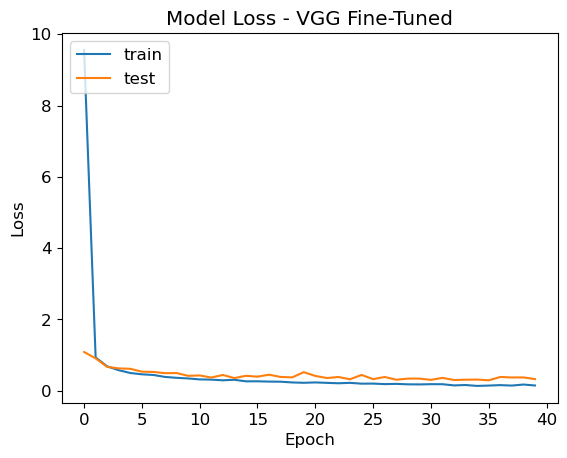

In [53]:
# summarize history for accuracy
plt.plot(finetune_vgg.history['accuracy'])
plt.plot(finetune_vgg.history['val_accuracy'])
plt.title('Model Accuracy - VGG Fine-Tuned')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(finetune_vgg.history['loss'])
plt.plot(finetune_vgg.history['val_loss'])
plt.title('Model Loss - VGG Fine-Tuned')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Again, this model performed similarly to the simple CNN but with worse overfitting. Let's take a closer look at the performance of the simple CNN, regularized CNN, and fine-tuned VGG.

## Model Comparison and Selection

To examine the results of each model, we'll need to generate predictions for our test data and compare them to the true classes.

In [59]:
# generate predictions for three top models
y_pred_conv = model_conv.predict(test_generator_aug, batch_size = batch_size)
y_pred_conv_drop = model_conv_drop.predict(test_generator_aug, batch_size = batch_size)
y_pred_vgg = vggmodel.predict(test_generator_vgg)
y_pred_vgg_finetune = vggmodel_finetune.predict(test_generator_vgg)

49/49 [==============================] - 2s 35ms/step


2023-04-14 23:45:42.067956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 12s 250ms/step


In [60]:
# specify true and predicted classes for each model
y_pred_classes_conv = np.argmax(y_pred_conv, axis=1)
y_true_classes_conv = test_generator_aug.classes
y_pred_classes_conv_drop = np.argmax(y_pred_conv_drop, axis=1)
y_true_classes_conv_drop = test_generator_aug.classes
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)
y_true_classes_vgg = test_generator_vgg.classes
y_pred_classes_vgg_finetune = np.argmax(y_pred_vgg_finetune, axis=1)
y_true_classes_vgg_finetune = test_generator_vgg.classes

In [61]:
# confirm order of classes for each generator
print(test_generator_aug.class_indices.keys())
print(test_generator_vgg.class_indices.keys())

dict_keys(['glioma', 'meningioma', 'notumor', 'other', 'pituitary'])
dict_keys(['glioma', 'meningioma', 'notumor', 'other', 'pituitary'])


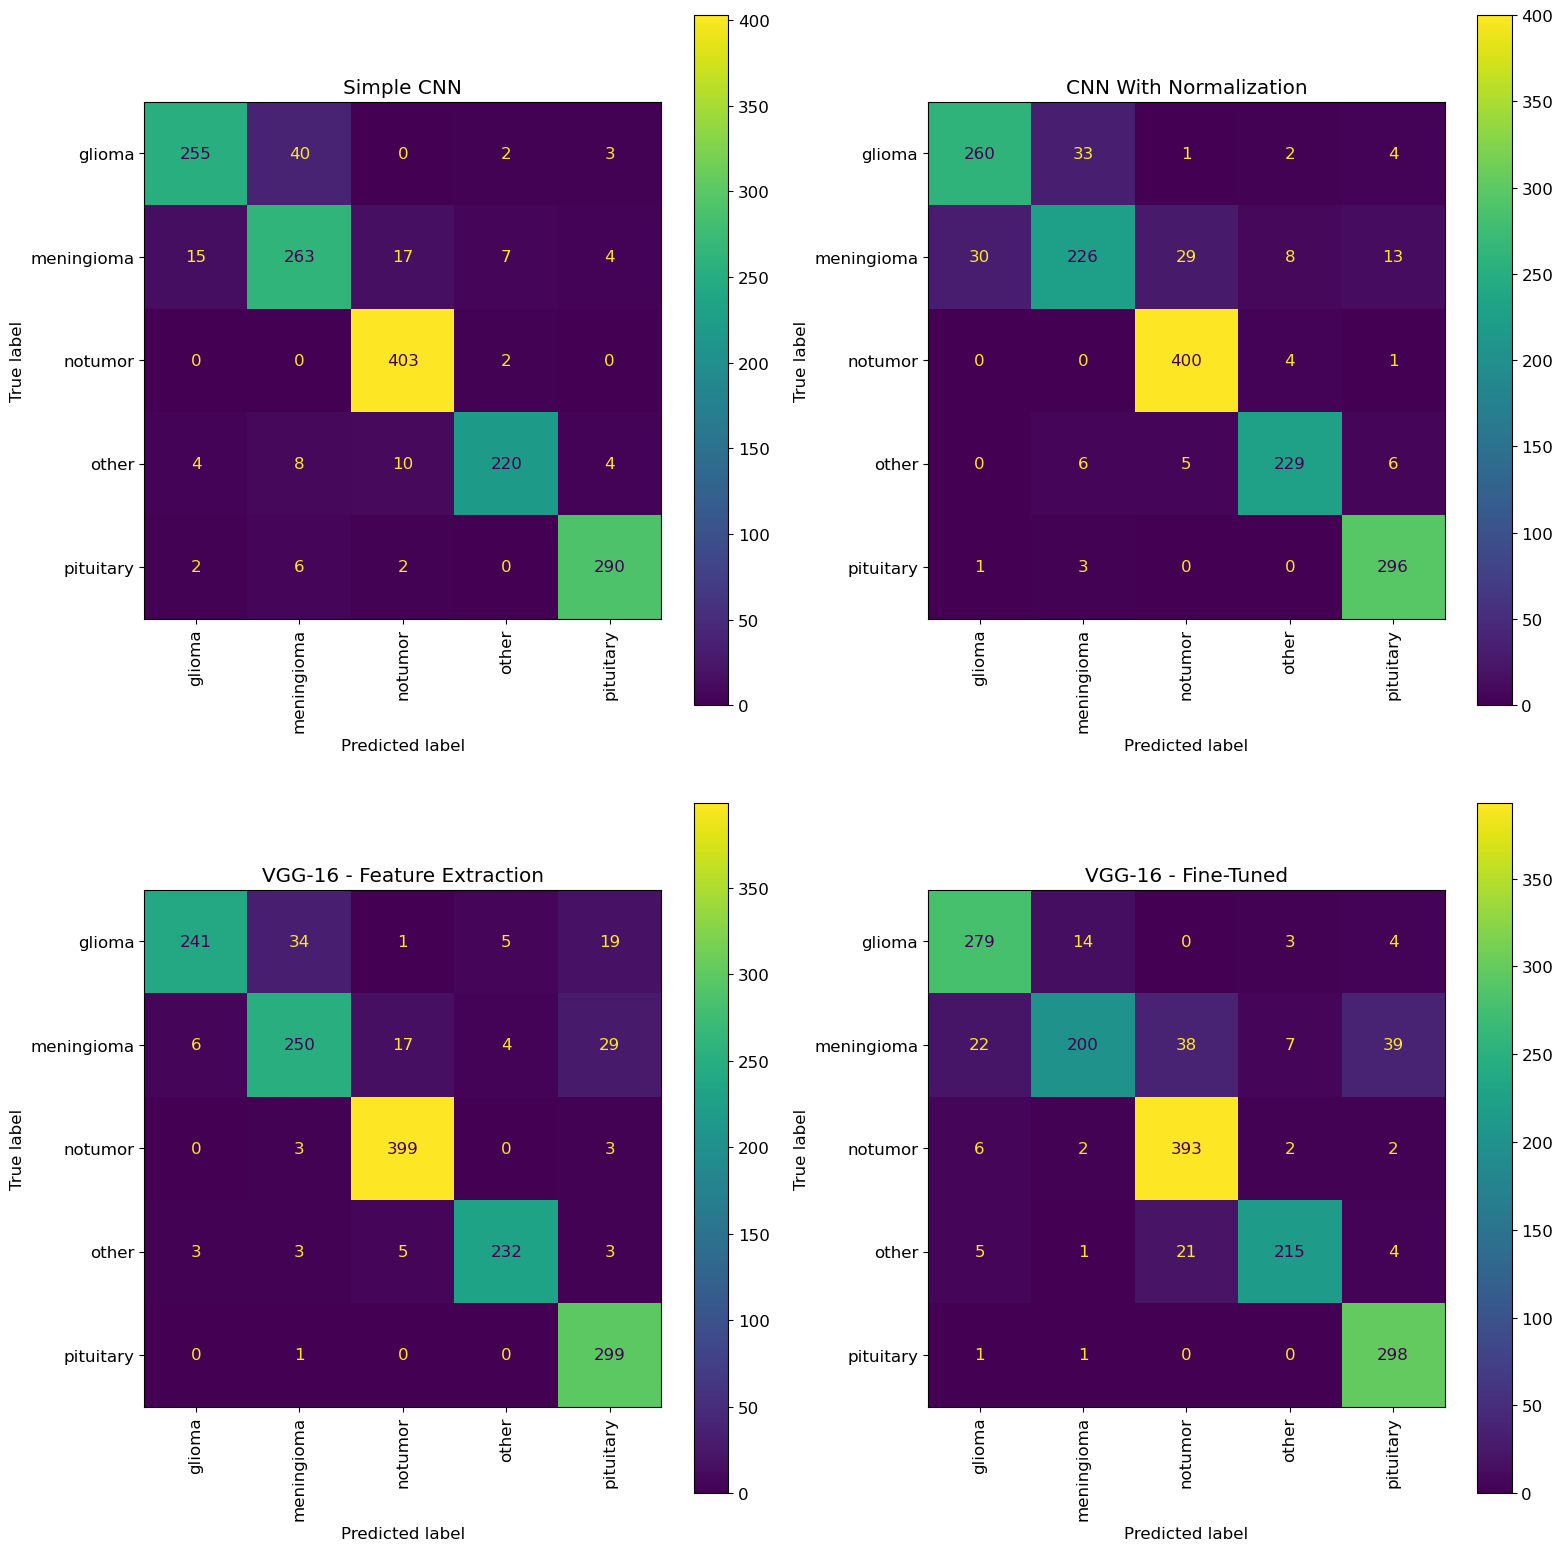

In [63]:
# instantiate figure
fig, axes = plt.subplots(figsize = (16, 16), ncols = 2, nrows = 2)
report_labels = ['glioma', 'meningioma', 'notumor', 'other', 'pituitary']

# plot confusion matrices for each model
ConfusionMatrixDisplay.from_predictions(y_true_classes_conv, y_pred_classes_conv, 
                                        display_labels = report_labels,
                                        xticks_rotation = 90,
                                        ax = axes[0, 0])
ConfusionMatrixDisplay.from_predictions(y_true_classes_conv_drop, y_pred_classes_conv_drop, 
                                        display_labels = report_labels,
                                        xticks_rotation = 90,
                                        ax = axes[0, 1])
ConfusionMatrixDisplay.from_predictions(y_true_classes_vgg, y_pred_classes_vgg, 
                                        display_labels = report_labels,
                                        xticks_rotation = 90,
                                        ax = axes[1, 0])
ConfusionMatrixDisplay.from_predictions(y_true_classes_vgg_finetune, y_pred_classes_vgg_finetune, 
                                        display_labels = report_labels,
                                        xticks_rotation = 90,
                                        ax = axes[1, 1])

axes[0,0].set_title('Simple CNN')
axes[0,1].set_title('CNN With Normalization')
axes[1,0].set_title('VGG-16 - Feature Extraction')
axes[1,1].set_title('VGG-16 - Fine-Tuned')

plt.tight_layout()
plt.show();

In [64]:
print('Simple CNN')
print(classification_report(test_generator_aug.classes, y_pred_classes_conv, target_names = report_labels))
print('--------------------------------------------------------')
print('CNN With Regularization')
print(classification_report(test_generator_aug.classes, y_pred_classes_conv_drop, target_names = report_labels))
print('--------------------------------------------------------')
print('VGG-16 - Feature Extraction')
print(classification_report(test_generator_aug.classes, y_pred_classes_vgg, target_names = report_labels))
print('--------------------------------------------------------')
print('Fine-Tuned VGG-16')
print(classification_report(test_generator_vgg.classes, y_pred_classes_vgg_finetune, target_names = report_labels))

Simple CNN
              precision    recall  f1-score   support

      glioma       0.92      0.85      0.89       300
  meningioma       0.83      0.86      0.84       306
     notumor       0.93      1.00      0.96       405
       other       0.95      0.89      0.92       246
   pituitary       0.96      0.97      0.97       300

    accuracy                           0.92      1557
   macro avg       0.92      0.91      0.92      1557
weighted avg       0.92      0.92      0.92      1557

--------------------------------------------------------
CNN With Regularization
              precision    recall  f1-score   support

      glioma       0.89      0.87      0.88       300
  meningioma       0.84      0.74      0.79       306
     notumor       0.92      0.99      0.95       405
       other       0.94      0.93      0.94       246
   pituitary       0.93      0.99      0.95       300

    accuracy                           0.91      1557
   macro avg       0.90      0.90      

### Model Selection
Overall, each of the three models above performed relatively well in terms of both accuracy and overall recall. However, examining the confusion matrices allows us to dig deeper into where each model went wrong, and select our final model.

Of the tumor classes included, gliomas are the most serious diagnosis. The most common gliomas in adults are glioblastomas, which have a five-year survival rate of only 6.8 percent and an average length of survival after diagnosis of only 8 months. However, [early interventions could potentially improve the outcomes of glioblastoma patients](https://link.springer.com/article/10.1007/s11912-021-01157-0), and [MRIs can be a tool to help detect glioblastomas in their early stages.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6516039/) We want our model to correctly detect these cases as often as possible so the patient can follow up and start treatment appropriately. 

The CNN with regularization has the highest recall for gliomas at 94%, which means it correctly detected 94% of all the gliomas in the dataset - the highest rate of the three models by far. **Subsequently, we can select the CNN with regularization as our final model because it performs comparably to the other two on accuracy and overall recall while scoring the highest on recall for the most serious classification.**

In [ ]:
# save model for use in deployment
model_conv_drop.save('/Users/eli/Desktop/brain_tumor_CNN_classifier/final_model')

### Examining Incorrect Predictions
Now that we've selected a model, let's look more deeply at some of the incorrect predictions generated by that model to better understand what those images look like.

In [ ]:
# create new df with test data and corresponding predictions
tumor_test_df_preds = pd.concat([tumor_test_df, 
                            pd.Series(y_pred_classes_conv_drop, name = 'pred_label')], 
                            axis = 1)
tumor_test_df_preds

In [ ]:
# relabel predictions
pred_dict = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'other', 4: 'pituitary'}
tumor_test_df_preds['pred_label'].replace(pred_dict, inplace = True)
tumor_test_df_preds

In [ ]:
# create df with subset of only incorrect predictions
wrong_preds = tumor_test_df_preds.loc[tumor_test_df_preds['label'] != 
                                      tumor_test_df_preds['pred_label']]
wrong_preds.reset_index(drop = True, inplace = True)
wrong_preds

In [ ]:
# open 16 images
images = open_images(wrong_preds['paths'][0:17])
labels = wrong_preds['label'][0:17]
pred_labels = wrong_preds['pred_label'][0:17]
fig = plt.figure(figsize=(12, 16))
for x in range(1, 17):
    fig.add_subplot(4, 4, x)
    plt.axis('off')
    plt.title(f'True: {labels[x]}\n Predicted: {pred_labels[x]}')
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Conclusions and Next Steps
This project built on existing work in the brain tumor detection space by expanding the number of classes in the dataset. The selected model achieved an overall accuracy, precision, and recall of roughly 90%, while achieving a recall of 94% for the most serious diagnosis in the dataset. In order to be more broadly applicable, the model would need to be trained on a wider variety of tumor images, as well as images of other potential diagnoses detectable by MRI such as blood clots, aneurysms, dementia, and others.

Some next steps I would like to take are:

1. Preprocess the images further by thresholding and cropping the skull/brain, to reduce the amount of black space and other potential noise present in each image before modeling.
2. Expand the number of classes further to make more granular classification predictions possible.
3. Test additional transfer learning approaches, such as the one [proposed in this paper.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9600529/)